In [1]:
import MIMENetEnsemble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set path to simulation data
simulation_path = "../data/simulation_data/experimental_conditions"

In [3]:
#set training parameters
training_path = "../data/simulation_data/experimental_conditions/second_round/"
epochs = 100
learning_rate = 0.00001
batch_size = 2**16
lambda_l2 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2

In [4]:
model, history = MIMENetEnsemble.train(
    training_path=training_path+'parsed_reads.txt',
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l2=lambda_l2,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    kd_path="../data/simulation_data/experimental_conditions/secondFromProt1/prot1/single_kds.txt",
    model_path=None
)

Device: cuda:0
Number of training examples: 12845669


100%|██████████| 100/100 [20:57:25<00:00, 754.46s/it]  


In [5]:
#save model
torch.save(model.state_dict(), './ensembleExpCond.pth')

In [6]:
#save training history as json
with open('./history_exp_ens.json', 'w') as f:
    json.dump(history, f)

In [4]:
#load saved model, training history, and prediction history
input_size = len(open(training_path+'parsed_reads.txt').readline().split('_')[0])
model = MIMENetEnsemble.MIMENetEnsemble(input_size, hidden_size_factor, bottleneck, 1)
model.load_state_dict(torch.load('./ensembleExpCond.pth'))
#puto model to gpu
model.to('cuda:0')
#load history
with open('./history_exp_ens.json', 'r') as f:
    history = json.load(f)

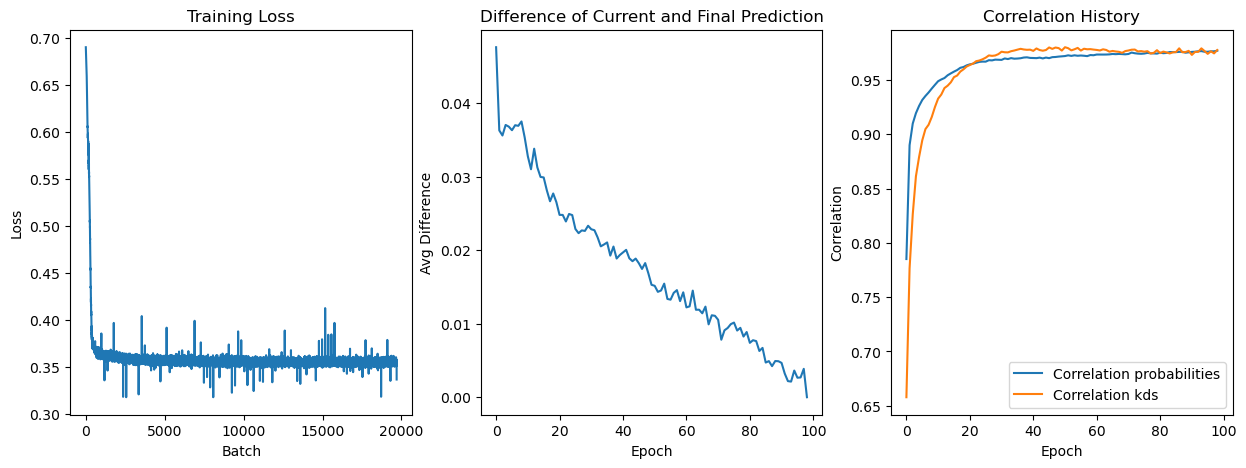

In [8]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

#plot correlation history rows as lines
axs[2].plot(history['correlation_probs'][1:], label='Correlation probabilities')
axs[2].plot(history['correlation_kds'][1:], label='Correlation kds')
axs[2].legend()
axs[2].set_title("Correlation History")
axs[2].set_ylabel("Correlation")
axs[2].set_xlabel("Epoch")
plt.show()

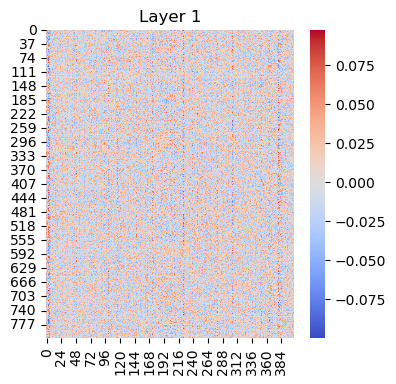

max weight value:  0.09769235
min weight value:  -0.099860236
number of pruned weights:  0
number of non zero weights:  329672
max bias value:  0.05426122
min bias value:  -0.056069545
number of pruned biases:  0
number of non zero biases:  812


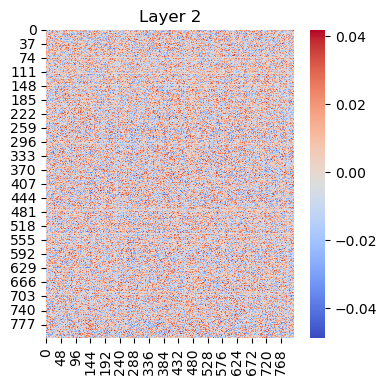

max weight value:  0.041756056
min weight value:  -0.04865196
number of pruned weights:  0
number of non zero weights:  659344
max bias value:  0.039386738
min bias value:  -0.03375034
number of pruned biases:  0
number of non zero biases:  812


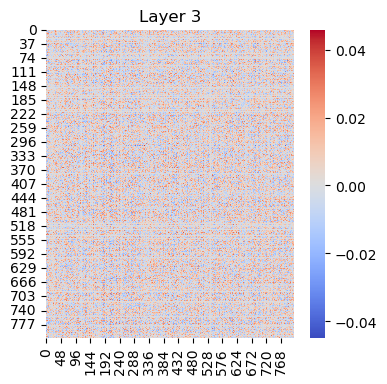

max weight value:  0.04585684
min weight value:  -0.044783864
number of pruned weights:  0
number of non zero weights:  659344
max bias value:  0.04206596
min bias value:  -0.042869847
number of pruned biases:  0
number of non zero biases:  812


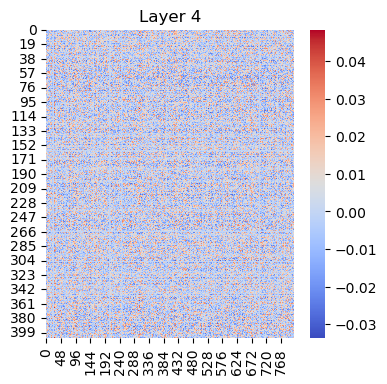

max weight value:  0.048383903
min weight value:  -0.033602927
number of pruned weights:  0
number of non zero weights:  329672
max bias value:  0.04246635
min bias value:  -0.031113453
number of pruned biases:  0
number of non zero biases:  406


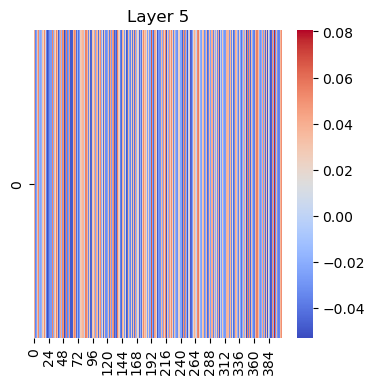

max weight value:  0.0807747
min weight value:  -0.052715506
number of pruned weights:  0
number of non zero weights:  406
max bias value:  -0.02294285
min bias value:  -0.02294285
number of pruned biases:  0
number of non zero biases:  1


In [9]:
for name, param in model.named_parameters():
    #if weight is not a bias
    if 'bias' not in name:
        #reshape weights to 2d array
        weight = param.data.cpu().numpy().reshape(param.data.cpu().numpy().shape[0], param.data.cpu().numpy().shape[1])
        #plot heatmap of weights
        plt.figure(figsize=(4,4))
        sns.heatmap(weight, cmap='coolwarm')
        # get layer number from name
        layer = [int(s) for s in name if s.isdigit()]
        plt.title(f'Layer {layer[0]}')
        plt.show()

        print('max weight value: ', np.max(weight))
        print('min weight value: ', np.min(weight))
        print('number of pruned weights: ', np.sum(weight == 0))
        print('number of non zero weights: ', np.sum(weight != 0))

    else:
        bias = param.data.cpu().numpy()
 
        print('max bias value: ', np.max(bias))
        print('min bias value: ', np.min(bias))
        print('number of pruned biases: ', np.sum(bias == 0))
        print('number of non zero biases: ', np.sum(bias != 0))

In [5]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
single_kd_sim = np.insert(single_kd_sim, 0, 1)
single_kd_sim = np.insert(single_kd_sim, np.arange(4, len(single_kd_sim), 3), 1)
single_kd_sim[0:10]

array([1.     , 1.     , 1.     , 2.49155, 1.     , 2.68604, 1.     ,
       1.     , 1.     , 1.     ])

In [11]:
input_size = len(open(training_path+'parsed_reads.txt').readline().split('_')[0])
single_prob_pred = MIMENetEnsemble.inferSingleProbabilities(model, input_size, 1000)

In [12]:
single_prob_pred = np.array(single_prob_pred)
single_prob_pred_means = np.mean(single_prob_pred, axis=1)
single_prob_pred_conf = np.zeros((single_prob_pred_means.shape[0], 2))
for i in range(single_prob_pred_means.shape[0]):
    single_prob_pred_conf[i] = np.quantile(single_prob_pred[i], [0.025, 0.975])

print(single_prob_pred_means[0:10])
print(single_prob_pred_conf[0:10])

[0.45337715 0.47609813 0.45999828 0.29650326 0.45476829 0.27664698
 0.45970436 0.44827666 0.46205018 0.44145418]
[[0.42150525 0.48178529]
 [0.44650905 0.50238512]
 [0.42657799 0.49077109]
 [0.26357325 0.32681341]
 [0.4215913  0.4854433 ]
 [0.24407806 0.30935424]
 [0.42893525 0.49008974]
 [0.41592637 0.47809649]
 [0.4317873  0.48851485]
 [0.40894481 0.47170931]]


Text(0.8, 0.1, 'r = 0.98')

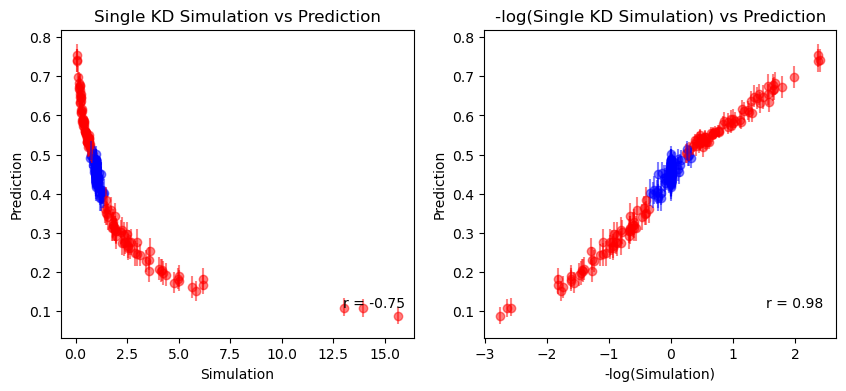

In [13]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# every 4th value is wildtype, get indices of wildtype values
wt_indices = np.arange(0, len(single_kd_sim), 4)

# go through all indices
for i in range(len(single_kd_sim)):
    # if index is wildtype
    if i in wt_indices:
        continue
    
    # get index of wildtype value
    wt_index = i - (i % 4)
    # get interval of wildtype value
    wt_interval = single_prob_pred_conf[wt_index]
    # get interval of current value
    interval = single_prob_pred_conf[i]
    # if intervals do not overlap plot in red
    if wt_interval[0] > interval[1] or wt_interval[1] < interval[0]:
        ax1.scatter(single_kd_sim[i], single_prob_pred_means[i], color='red', alpha=0.5)
        ax1.vlines(single_kd_sim[i], single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='red', alpha=0.5)
    else:
        ax1.scatter(single_kd_sim[i], single_prob_pred_means[i], color='blue', alpha=0.5)
        ax1.vlines(single_kd_sim[i], single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='blue', alpha=0.5)

ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# add correlation coefficient to plot
ax1.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, single_prob_pred_means)[0, 1]:.2f}', transform=ax1.transAxes)


# every 4th value is wildtype, get indices of wildtype values
wt_indices = np.arange(0, len(single_kd_sim), 4)
# go through all indices
for i in range(len(single_kd_sim)):
    # if index is wildtype
    if i in wt_indices:
        continue
    
    # get index of wildtype value
    wt_index = i - (i % 4)
    # get interval of wildtype value
    wt_interval = single_prob_pred_conf[wt_index]
    # get value of wildtype
    wt_value = single_prob_pred_means[wt_index]
    # get interval of current value
    interval = single_prob_pred_conf[i]
    # get value of current value
    value = single_prob_pred_means[i]
    # if intervals do not overlap plot in red
    if wt_interval[0] > interval[1] or wt_interval[1] < interval[0]:
        ax2.scatter(-np.log(single_kd_sim[i]), single_prob_pred_means[i], color='red', alpha=0.5)
        ax2.vlines(-np.log(single_kd_sim[i]), single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='red', alpha=0.5)
    else:
        ax2.scatter(-np.log(single_kd_sim[i]), single_prob_pred_means[i], color='blue', alpha=0.5)
        ax2.vlines(-np.log(single_kd_sim[i]), single_prob_pred_conf[i, 0], single_prob_pred_conf[i, 1], color='blue', alpha=0.5)

ax2.set_title('-log(Single KD Simulation) vs Prediction')
ax2.set_xlabel('-log(Simulation)')
ax2.set_ylabel('Prediction')
# add correlation coefficient to plot
ax2.text(0.8, 0.1, f'r = {np.corrcoef(-np.log(single_kd_sim), single_prob_pred_means)[0, 1]:.2f}', transform=ax2.transAxes)

In [14]:
# constructing confusion matrix for probabilities

prob_fp = 0
prob_fn = 0
prob_tp = 0
prob_tn = 0
# iterate through all values
for i in range(len(single_kd_sim)):
    if i in wt_indices:
        continue
    # get index of wildtype value
    wt_index = i - (i % 4)
    wt_interval = single_prob_pred_conf[wt_index]
    interval = single_prob_pred_conf[i]
    # if intervals do not overlap > positive
    if wt_interval[0] > interval[1] or wt_interval[1] < interval[0]:
        # if simulation is negative
        if single_kd_sim[i] == 1:
            prob_fp += 1
        # if simulation is positive
        else:
            prob_tp += 1
    # if intervals overlap > negative
    else:
        # if simulation is negative
        if single_kd_sim[i] == 1:
            prob_tn += 1
        # if simulation is positive
        else:
            prob_fn += 1

# print confusion matrix
print('Confusion Matrix - Probabilities:'+ '\n')
print(f'{"":>10}{"Simulation+":>10}{"Simulation-"}')
print(f'{"Prediction+":>10}{prob_tp:>10}{prob_fp:>10}')
print(f'{"Prediction-":>10}{prob_fn:>10}{prob_tn:>10}')

# print accuracy
print(f'Accuracy: {(prob_tp + prob_tn) / (prob_tp + prob_fp + prob_fn + prob_tn):.2f}' + '\n')

Confusion Matrix - Probabilities:

          Simulation+Simulation-
Prediction+       119         0
Prediction-        28       153
Accuracy: 0.91



In [6]:
# read in kd values
single_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/single_kds.txt')

In [16]:
#predict kds
single_kd_pred = MIMENetEnsemble.inferSingleKds(model, input_size, 1000)

100%|██████████| 100/100 [04:35<00:00,  2.75s/it]


In [17]:
single_kd_pred = np.array(single_kd_pred)
single_kd_pred_means = np.mean(single_kd_pred, axis=1)
single_kd_pred_conf = np.zeros((single_kd_pred_means.shape[0], 2))
for i in range(single_kd_pred_means.shape[0]):
    single_kd_pred_conf[i] = np.quantile(single_kd_pred[i], [0.025, 0.975])

print(single_kd_pred_means[0:10])
print(single_kd_pred_means.shape)
print(single_kd_pred_conf[0:10])
print(single_kd_pred_conf.shape)

[0.91638886 0.97833492 1.98806711 2.17699136 0.98337433 1.03107797
 1.09682305 0.75840088 1.91167806 1.10002718]
(300,)
[[0.78241795 1.0863099 ]
 [0.81677807 1.16482298]
 [1.60637928 2.39119162]
 [1.7998371  2.62139179]
 [0.81897764 1.17170939]
 [0.86298312 1.22384716]
 [0.92579562 1.30517357]
 [0.65925587 0.8543355 ]
 [1.56103967 2.28222645]
 [0.92572275 1.31257054]]
(300, 2)


Text(0.6, 0.2, 'y = 0.71x + 0.03')

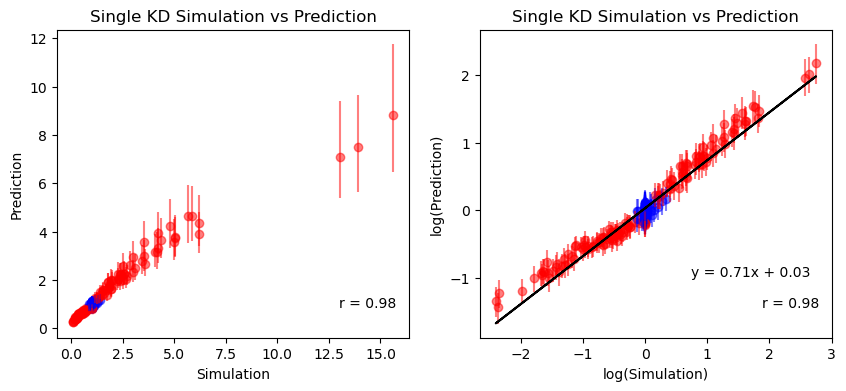

In [18]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], single_kd_pred_means[i], color='red', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], single_kd_pred_conf[i, 0], single_kd_pred_conf[i, 1], color='red', alpha=0.5)
    else:
        # scatter plot value
        ax1.scatter(single_kd_sim[i], single_kd_pred_means[i], color='blue', alpha=0.5)
        # plot interval
        ax1.vlines(single_kd_sim[i], single_kd_pred_conf[i, 0], single_kd_pred_conf[i, 1], color='blue', alpha=0.5)
ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# add correlation coefficient to plot
ax1.text(0.8, 0.1, f'r = {np.corrcoef(single_kd_sim, single_kd_pred_means)[0, 1]:.2f}', transform=ax1.transAxes)

# everything with log transformed kd
# iterate through all values
for i in range(len(single_kd_sim)):
    # get interval of current value
    interval = single_kd_pred_conf[i]
    # get value of current value
    value = single_kd_pred_means[i]
    # if interval does not contain 1, plot in red
    if interval[0] > 1 or interval[1] < 1:
        # scatter plot value
        ax2.scatter(np.log(single_kd_sim[i]), np.log(single_kd_pred_means[i]), color='red', alpha=0.5)
        # plot interval
        ax2.vlines(np.log(single_kd_sim[i]), np.log(single_kd_pred_conf[i, 0]), np.log(single_kd_pred_conf[i, 1]), color='red', alpha=0.5)
    else:
        # scatter plot value
        ax2.scatter(np.log(single_kd_sim[i]), np.log(single_kd_pred_means[i]), color='blue', alpha=0.5)
        # plot interval
        ax2.vlines(np.log(single_kd_sim[i]), np.log(single_kd_pred_conf[i, 0]), np.log(single_kd_pred_conf[i, 1]), color='blue', alpha=0.5)

ax2.set_title('Single KD Simulation vs Prediction')
ax2.set_xlabel('log(Simulation)')
ax2.set_ylabel('log(Prediction)')
# add correlation coefficient to plot
ax2.text(0.8, 0.1, f'r = {np.corrcoef(np.log(single_kd_sim), np.log(single_kd_pred_means))[0, 1]:.2f}', transform=ax2.transAxes)
# add line of best fit
ax2.plot(np.log(single_kd_sim), np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_means), 1))(np.log(single_kd_sim)), color='black')
# add equation of line of best fit rounded to 2 decimal places
ax2.text(0.6, 0.2, f'y = {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_means), 1))[1]:.2f}x + {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_means), 1))[0]:.2f}', transform=ax2.transAxes)


In [19]:
# construct confusion matrix for kd values

kd_tp = 0
kd_fp = 0
kd_fn = 0
kd_tn = 0

# iterate through all values
for i in range(len(single_kd_sim)):
    interval = single_kd_pred_conf[i]
    # if interval does not contain 1 > positive
    if interval[0] > 1 or interval[1] < 1:
        # if simulation is 1 > negative
        if single_kd_sim[i] == 1:
            kd_fp += 1
        # if simulation is not 1 > positive
        else:
            kd_tp += 1
    # if interval contains 1 > negative
    else:
        # if simulation is 1 > positive
        if single_kd_sim[i] == 1:
            kd_tn += 1
        # if simulation is not 1 > negative
        else:
            kd_fn += 1

# print confusion matrix
print('Confusion Matrix - Kd values:'+ '\n')
print(f'{"":>10}{"Simulation+":>10}{"Simulation-"}')
print(f'{"Prediction+":>10}{kd_tp:>10}{kd_fp:>10}')
print(f'{"Prediction-":>10}{kd_fn:>10}{kd_tn:>10}')

# print accuracy
print(f'Accuracy: {(kd_tp + kd_tn) / (kd_tp + kd_fp + kd_fn + kd_tn):.2f}')

Confusion Matrix - Kd values:

          Simulation+Simulation-
Prediction+       131         5
Prediction-        16       148
Accuracy: 0.93


In [7]:
# infer single kd values per protein concentration
single_kd_pred_per_prot = MIMENetEnsemble.inferSingleKdsProtein(model=model, numberFeatures=input_size, n=100, number_protein_concentrations=3)

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


In [9]:
# print keys of single_kd_pred_per_prot
print(single_kd_pred_per_prot.keys())

dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])


In [10]:
single_kd_pred_per_prot_mean = {}

# iterate throug keys
for key in single_kd_pred_per_prot.keys():
    single_kd_pred_per_prot_mean[key] = np.mean(np.array(single_kd_pred_per_prot[key]), axis=1)

Linear Fit:
(0, 0): y = 0.54x + 0.55
(0, 1): y = 0.44x + 0.57
(0, 2): y = 0.29x + 0.62
(1, 0): y = 0.43x + 0.60
(1, 1): y = 0.28x + 0.68
(1, 2): y = 0.26x + 0.69
(2, 0): y = 0.44x + 0.56
(2, 1): y = 0.27x + 0.71
(2, 2): y = 0.24x + 0.73
Log Fit:
(0, 0): y = 0.79x + 0.08
(0, 1): y = 0.73x + 0.01
(0, 2): y = 0.52x + -0.06
(1, 0): y = 0.70x + 0.03
(1, 1): y = 0.49x + -0.01
(1, 2): y = 0.48x + -0.02
(2, 0): y = 0.68x + 0.02
(2, 1): y = 0.41x + 0.02
(2, 2): y = 0.48x + -0.01


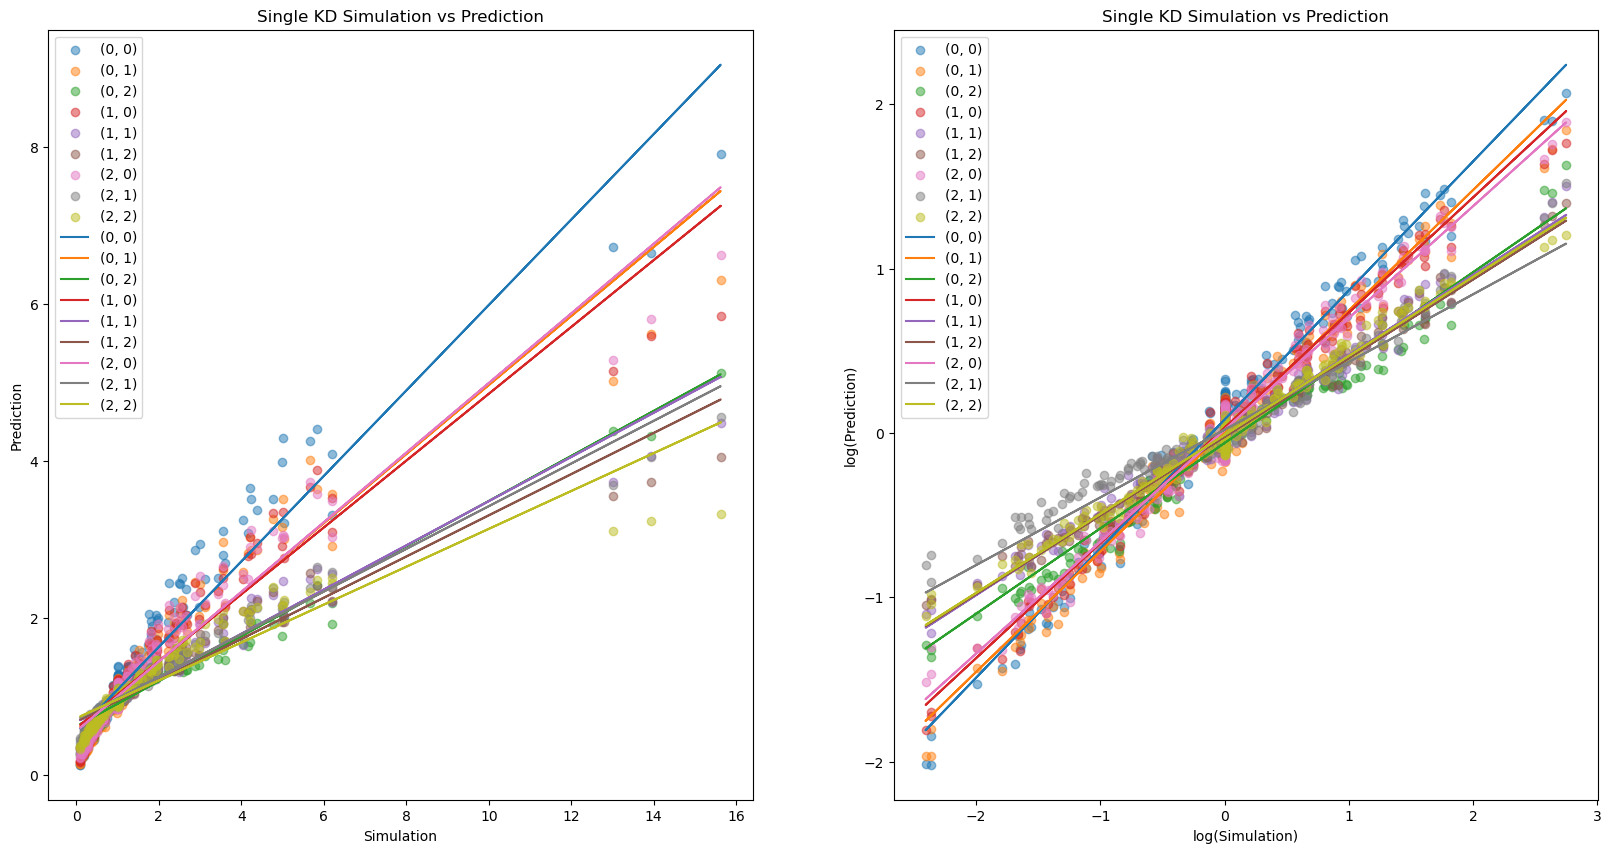

In [28]:
#per key plot single_kd_pred_per_prot_mean at key vs singlew_kd_sim
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
for key in single_kd_pred_per_prot_mean.keys():
    ax1.scatter(single_kd_sim, single_kd_pred_per_prot_mean[key], label=key, alpha=0.5)
ax1.set_title('Single KD Simulation vs Prediction')
ax1.set_xlabel('Simulation')
ax1.set_ylabel('Prediction')
# log scale
#ax1.set_xscale('log')
#ax1.set_yscale('log')
# per ey fit linear line
print('Linear Fit:')
for key in single_kd_pred_per_prot_mean.keys():
    ax1.plot(single_kd_sim, np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_per_prot_mean[key], 1))(single_kd_sim), label=key)
    # print equation of line
    print(f'{key}: y = {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_per_prot_mean[key], 1))[1]:.2f}x + {np.poly1d(np.polyfit(single_kd_sim, single_kd_pred_per_prot_mean[key], 1))[0]:.2f}')
ax1.legend()

# log scale
for key in single_kd_pred_per_prot_mean.keys():
    ax2.scatter(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), label=key, alpha=0.5)
ax2.set_title('Single KD Simulation vs Prediction')
ax2.set_xlabel('log(Simulation)')
ax2.set_ylabel('log(Prediction)')
print('Log Fit:')
# per ey fit linear line
for key in single_kd_pred_per_prot_mean.keys():
    ax2.plot(np.log(single_kd_sim), np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), 1))(np.log(single_kd_sim)), label=key)
    # print equation of line
    print(f'{key}: y = {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), 1))[1]:.2f}x + {np.poly1d(np.polyfit(np.log(single_kd_sim), np.log(single_kd_pred_per_prot_mean[key]), 1))[0]:.2f}')
ax2.legend()

In [20]:
#load pairwise kd values
pair_kd_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_kds.txt')

In [21]:
#predict pairwise probabilities
pair_prob_pred = MIMENetEnsemble.inferPairwiseProbabilities(model, input_size, 100)

100%|██████████| 100/100 [34:13<00:00, 20.54s/it]


In [22]:
pair_prob_pred = np.array(pair_prob_pred)
pair_prob_pred_means = np.mean(pair_prob_pred, axis=1)
pair_prob_pred_conf = np.zeros((pair_prob_pred_means.shape[0], 2))
for i in range(pair_prob_pred_means.shape[0]):
    pair_prob_pred_conf[i] = np.quantile(pair_prob_pred[i], [0.025, 0.975])

print(pair_prob_pred_means[0:10])
print(pair_prob_pred_conf[0:10])

[0.27042183 0.46034321 0.44374559 0.2626472  0.44823964 0.4455571
 0.14549626 0.28387569 0.25934129 0.4443321 ]
[[0.23568628 0.30282821]
 [0.43078328 0.49361984]
 [0.40427088 0.47301181]
 [0.23498849 0.29543307]
 [0.42039555 0.47614081]
 [0.4122796  0.47808555]
 [0.11785587 0.17748551]
 [0.25031721 0.32144573]
 [0.22343564 0.29215109]
 [0.41467324 0.47981584]]


Text(0.8, 0.1, 'r = 0.98')

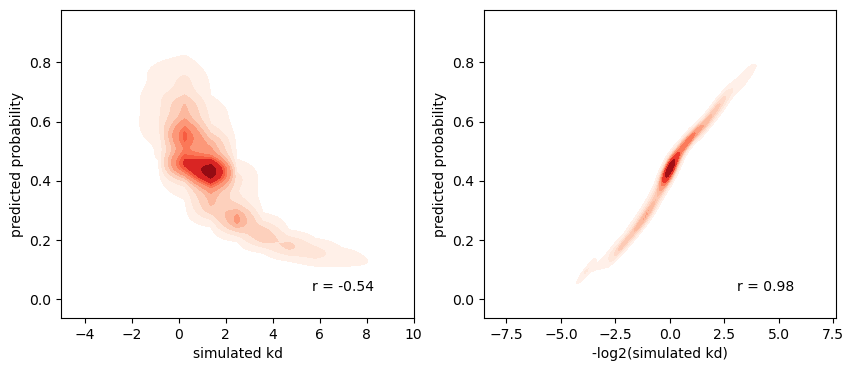

In [23]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_prob_pred_means, cmap='Reds', fill=True, ax=ax1)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
sns.kdeplot(x=-np.log2(pair_kd_sim), y=pair_prob_pred_means, cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

Text(0.8, 0.1, 'r = 0.98')

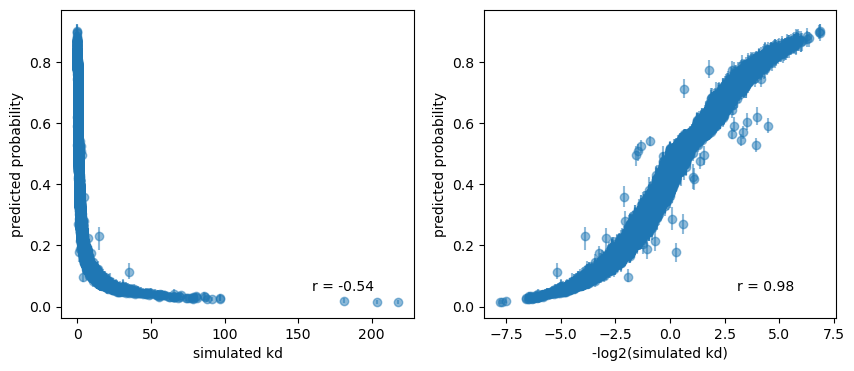

In [24]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred as kde plot
ax1.scatter(x=pair_kd_sim, y=pair_prob_pred_means, alpha=0.5)
ax1.vlines(x=pair_kd_sim, ymin=pair_prob_pred_conf[:,0], ymax=pair_prob_pred_conf[:,1], alpha=0.5)
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred) as kde plot
ax2.scatter(x=-np.log2(pair_kd_sim), y=pair_prob_pred_means, alpha=0.5)
ax2.vlines(x=-np.log2(pair_kd_sim), ymin=pair_prob_pred_conf[:,0], ymax=pair_prob_pred_conf[:,1], alpha=0.5)
ax2.set_xlabel('-log2(simulated kd)')
ax2.set_ylabel('predicted probability')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(-np.log2(pair_kd_sim), pair_prob_pred_means)[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)

In [25]:
#predict pairwise kds
pair_kd_pred = MIMENetEnsemble.inferPairwiseKds(model, input_size, 100)

100%|██████████| 100/100 [1:08:11<00:00, 40.92s/it]


In [26]:
# save pair_kd_pred
np.savetxt('./pair_kd_pred.txt', pair_kd_pred)

In [27]:
# load pair_kd_pred
pair_kd_pred = np.loadtxt('./pair_kd_pred.txt')

In [28]:
pair_kd_pred = np.array(pair_kd_pred)
pair_kd_pred_means = np.mean(pair_kd_pred, axis=1)
pair_kd_pred_conf = np.zeros((pair_kd_pred_means.shape[0], 2))
for i in range(pair_kd_pred_means.shape[0]):
    pair_kd_pred_conf[i] = np.quantile(pair_kd_pred[i], [0.025, 0.975])

print(pair_kd_pred_means[0:10])
print(pair_kd_pred_conf[0:10])

[2.0385201  0.87265145 0.93073015 2.06847013 0.9313875  0.91879716
 4.3745944  1.83348876 2.11563212 1.01008418]
[[1.61265454 2.44472263]
 [0.7187145  1.03130665]
 [0.7668191  1.10433423]
 [1.56637606 2.52769386]
 [0.77574419 1.0939702 ]
 [0.78943765 1.11687307]
 [3.36286731 5.68841505]
 [1.41813767 2.2068218 ]
 [1.72533458 2.57895465]
 [0.84616522 1.25735614]]


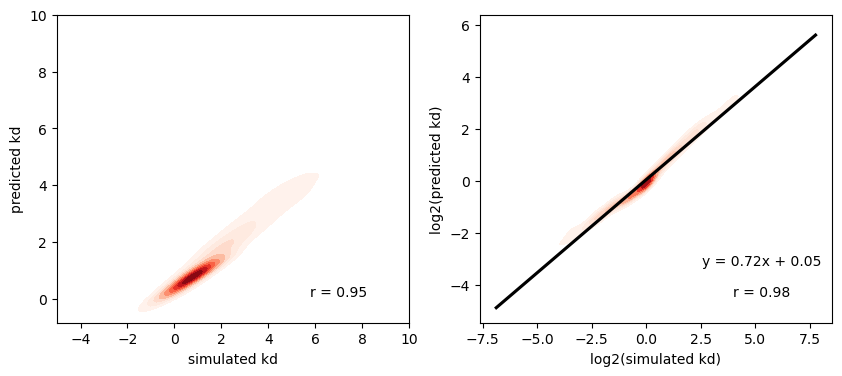

In [29]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred_means as kde plot
sns.kdeplot(x=pair_kd_sim, y=pair_kd_pred_means, cmap='Reds', fill=True, ax=ax1, clip=(-5, 10))
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#set x limit
ax1.set_xlim(-5, 10)
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred_means) as kde plot
sns.kdeplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred_means), cmap='Reds', fill=True, ax=ax2)
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred_means), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

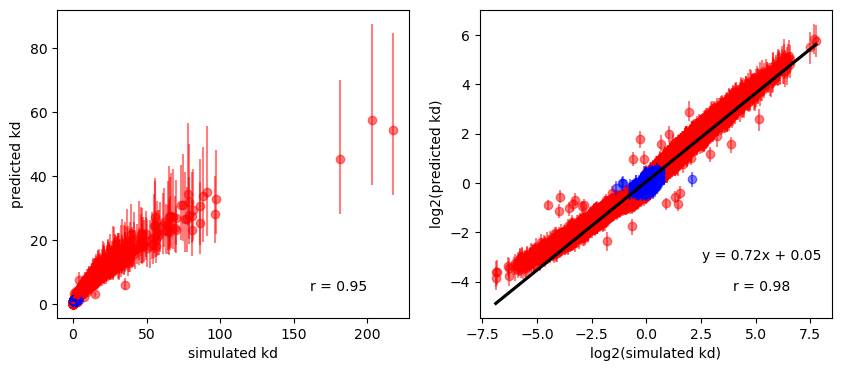

In [30]:
# get indices where interval does not contain 1
pair_kd_pred_conf_sig = np.where((pair_kd_pred_conf[:,0] > 1) | (pair_kd_pred_conf[:,1] < 1))
pair_kd_pred_conf_not_sig = np.where((pair_kd_pred_conf[:,0] < 1) & (pair_kd_pred_conf[:,1] > 1))
pair_kd_pred_means_sig = pair_kd_pred_means[pair_kd_pred_conf_sig]
pair_kd_pred_means_not_sig = pair_kd_pred_means[pair_kd_pred_conf_not_sig]

# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot pair_kd_sim vs pair_kd_pred_means as scatter plot
ax1.scatter(x=pair_kd_sim[pair_kd_pred_conf_sig], y=pair_kd_pred_means_sig, alpha=0.5, color='red')
ax1.vlines(x=pair_kd_sim[pair_kd_pred_conf_sig], ymin=pair_kd_pred_conf[pair_kd_pred_conf_sig,0], ymax=pair_kd_pred_conf[pair_kd_pred_conf_sig,1], alpha=0.5, color='red')
ax1.scatter(x=pair_kd_sim[pair_kd_pred_conf_not_sig], y=pair_kd_pred_means_not_sig, alpha=0.5, color='blue')
ax1.vlines(x=pair_kd_sim[pair_kd_pred_conf_not_sig], ymin=pair_kd_pred_conf[pair_kd_pred_conf_not_sig,0], ymax=pair_kd_pred_conf[pair_kd_pred_conf_not_sig,1], alpha=0.5, color='blue')
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred_means) as scatter plot
ax2.scatter(x=np.log2(pair_kd_sim[pair_kd_pred_conf_sig]), y=np.log2(pair_kd_pred_means_sig), alpha=0.5, color='red')
ax2.vlines(x=np.log2(pair_kd_sim[pair_kd_pred_conf_sig]), ymin=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_sig,0]), ymax=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_sig,1]), alpha=0.5, color='red')
ax2.scatter(x=np.log2(pair_kd_sim[pair_kd_pred_conf_not_sig]), y=np.log2(pair_kd_pred_means_not_sig), alpha=0.5, color='blue')
ax2.vlines(x=np.log2(pair_kd_sim[pair_kd_pred_conf_not_sig]), ymin=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_not_sig,0]), ymax=np.log2(pair_kd_pred_conf[pair_kd_pred_conf_not_sig,1]), alpha=0.5, color='blue')
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)
#show line of best fit
sns.regplot(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred_means), color='black', scatter=False, ax=ax2)
# show equation of line of best fit
plt.text(0.8, 0.2, 'y = '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[0], 2))+'x + '+str(np.round(np.polyfit(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means), 1)[1], 2)), ha='center', va='center', transform=plt.gca().transAxes)
plt.show()


In [31]:
# construct confusion matrix for kd values

kd_tp = 0
kd_fp = 0
kd_fn = 0
kd_tn = 0

# iterate through all values
for i in range(len(pair_kd_sim)):
    interval = pair_kd_pred_conf[i]
    # if interval does not contain 1 > positive
    if interval[0] > 1 or interval[1] < 1:
        # if simulation is 1 > negative
        if pair_kd_sim[i] == 1:
            kd_fp += 1
        # if simulation is not 1 > positive
        else:
            kd_tp += 1
    # if interval contains 1 > negative
    else:
        # if simulation is 1 > positive
        if pair_kd_sim[i] == 1:
            kd_tn += 1
        # if simulation is not 1 > negative
        else:
            kd_fn += 1

# print confusion matrix
print('Confusion Matrix - Kd values:'+ '\n')
print(f'{"":>10}{"Simulation+":>10}{"Simulation-"}')
print(f'{"Prediction+":>10}{kd_tp:>10}{kd_fp:>10}')
print(f'{"Prediction-":>10}{kd_fn:>10}{kd_tn:>10}')

# print accuracy
print(f'Accuracy: {(kd_tp + kd_tn) / (kd_tp + kd_fp + kd_fn + kd_tn):.2f}')

Confusion Matrix - Kd values:

          Simulation+Simulation-
Prediction+     28664       850
Prediction-      4331     10705
Accuracy: 0.88


In [32]:
# load simulated epistasis
epi_sim = np.loadtxt(simulation_path+'/secondFromProt1/prot1/pairwise_epistasis.txt')

In [33]:
# get indices where epistasis is not 1
epi_sim_not_1 = np.where(epi_sim != 1)[0]
len(epi_sim_not_1)

49

Text(0.8, 0.1, 'r = 0.98')

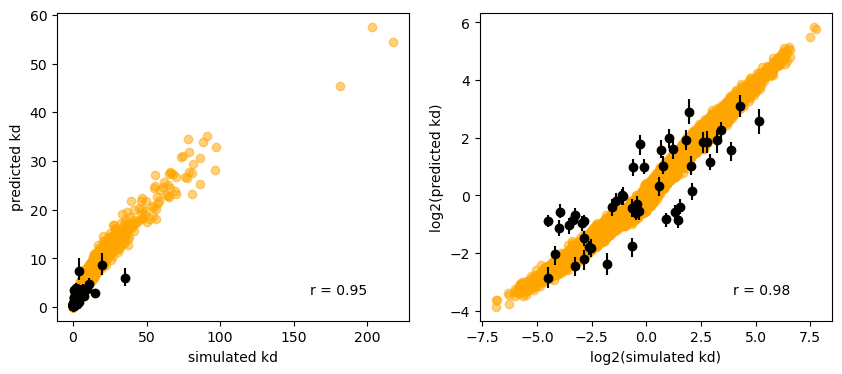

In [34]:
# set up 2 side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

#plot pair_kd_sim vs pair_kd_pred_means as scatter plot
ax1.scatter(x=pair_kd_sim, y=pair_kd_pred_means, alpha=0.5, color='orange')
#ax1.vlines(x=pair_kd_sim, ymin=pair_kd_pred_conf[:,0], ymax=pair_kd_pred_conf[:,1], alpha=0.5, color='orange')
ax1.scatter(x=pair_kd_sim[epi_sim_not_1], y=pair_kd_pred_means[epi_sim_not_1], color='black')
ax1.vlines(x=pair_kd_sim[epi_sim_not_1], ymin=pair_kd_pred_conf[epi_sim_not_1,0], ymax=pair_kd_pred_conf[epi_sim_not_1,1], color='black')
ax1.set_xlabel('simulated kd')
ax1.set_ylabel('predicted kd')
#show correlation coefficient in bottom right corner
ax1.text(0.8, 0.1, 'r = '+str(np.round(np.corrcoef(pair_kd_sim, pair_kd_pred_means)[0,1], 2)), ha='center', va='center', transform=ax1.transAxes)
#plot log2(pair_kd_sim) vs log2(pair_kd_pred_means) as scatter plot
ax2.scatter(x=np.log2(pair_kd_sim), y=np.log2(pair_kd_pred_means), alpha=0.5, color='orange')
#ax2.vlines(x=np.log2(pair_kd_sim), ymin=np.log2(pair_kd_pred_conf[:,0]), ymax=np.log2(pair_kd_pred_conf[:,1]), alpha=0.5, color='orange')
ax2.scatter(x=np.log2(pair_kd_sim[epi_sim_not_1]), y=np.log2(pair_kd_pred_means[epi_sim_not_1]), color='black')
ax2.vlines(x=np.log2(pair_kd_sim[epi_sim_not_1]), ymin=np.log2(pair_kd_pred_conf[epi_sim_not_1,0]), ymax=np.log2(pair_kd_pred_conf[epi_sim_not_1,1]), color='black')
ax2.set_xlabel('log2(simulated kd)')
ax2.set_ylabel('log2(predicted kd)')
#show correlation coefficient in bottom right corner
ax2.text(.8, .1, 'r = '+str(np.round(np.corrcoef(np.log2(pair_kd_sim), np.log2(pair_kd_pred_means))[0,1], 2)), ha='center', va='center', transform=ax2.transAxes)